# Import libraries

In [1]:
import numpy as np
import scipy.io as sio
from forward import TorchTomographySolver

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

import torch

In [2]:
def plot_result_torch(x, error):
    plt.cla()
    axes[0].imshow(x[:, :, x.shape[2]//2,0], cmap="gray", clim=(0, 100))
    axes[0].set_title("X-Y slice", fontsize=24)
    axes[1].plot(np.log10(error), marker='o', color='k', markerfacecolor="None", linestyle="None", markersize=12)
    axes[1].set_title("error", fontsize=24)
    if len(error)>1:
        error_max = np.log10(np.max(error))
        error_min = np.log10(np.min(error))
        y_range   = (error_max-error_min)
        axes[1].set_xlim(0, len(error))
        axes[1].set_ylim(error_min-0.1*y_range, error_max+0.1*y_range)
        axes[1].set_aspect(len(error)/(error_max-error_min+0.2*y_range))
    else:
        axes[1].axis("square")
        
    clear_output(wait=True)
    display(fig)

# Specify file path

In [3]:
fn = '/home/tomo/david_data/data/measurement/TEM_simulation_480_SiO2_py.mat'

# Load dataset

In [4]:
data = sio.loadmat(fn)
data["tilt_angles"] = np.float32(data["tilt_angles"])
data["defocus_stack"] = np.float32(data["defocus_stack"])
data["na"] = np.float32(data["na"])
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'pot_stack', 'dz', 'pixel_size', 'wavelength', 'sigma', 'amplitude_measure', 'tilt_angles', 'defocus_stack', 'na', 'obj_shape'])


# Define recon parameters

In [5]:
#Define pixel size
voxel_size = np.repeat(np.squeeze(data["pixel_size"]),3)

In [6]:
params = {
    "shape":                                          np.squeeze(data["obj_shape"]).tolist(),
    "voxel_size":                                     voxel_size,
    "wavelength":                                     data["wavelength"].item(),
    "sigma":                                          data["sigma"].item() * voxel_size[2],
    "tilt_angles":                                    np.squeeze(data["tilt_angles"]),
    "defocus_stack":                                  np.squeeze(data["defocus_stack"]),
    "amplitude_measurements" :                        np.squeeze(data["amplitude_measure"]),
    "numerical_aperture":                             1.0,
    "binning_factor":                                 5, 
    "pad_size":                                       [60,60],
    "maxitr":                                         40,
    "step_size":                                      1e4,
    "batch_size":                                     1,
    "shuffle":                                        False,
    "pupil":                                          None,
    "regularizer_total_variation":                    True,                    
    "regularizer_total_variation_gpu":                True,
    "regularizer_total_variation_parameter":          1.0,
    "regularizer_total_variation_maxitr":             15,
    "regularizer_total_variation_anisotropic":        False, #anisotropic TV, saves GPU space
    "regularizer_total_variation_order":              1, #do not change
    "regularizer_pure_real":                          True,
    "regularizer_pure_imag":                          False, #do not change
    "regularizer_pure_amplitude":                     False, #do not change
    "regularizer_pure_phase":                         False, #do not change
    "regularizer_positivity_real":                    True, 
    "regularizer_positivity_imag":                    False, #do not change
    "regularizer_negativity_real":                    False, #do not change
    "regularizer_negativity_imag":                    False, #do not change
}

In [7]:
solver_obj = TorchTomographySolver(**params)

Regularizer - Total Variation+positivity_real


# Start recon

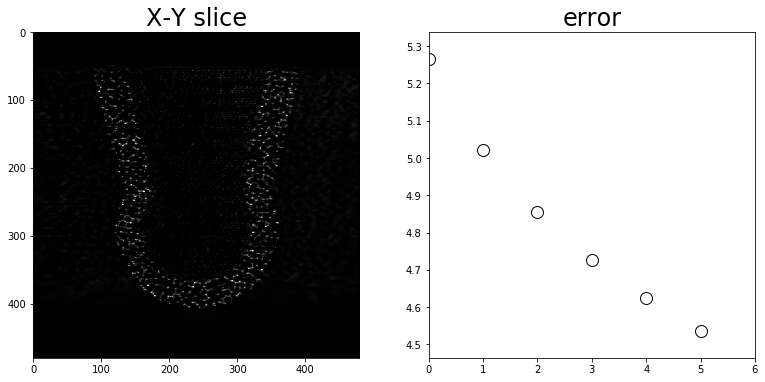

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
output = solver_obj.run(callback=plot_result_torch)